In [1]:
import glob
import random
import math
import decimal
import re
import pandas as pd
import numpy as np

from sklearn import decomposition

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

set random seed

In [47]:
random.seed(11915043)

<H2> P1 : IRIS – HIERARCHICAL FISHER </H2>

In [3]:
iris = pd.read_csv('DMG-2 Assignment Data Files/iris/iris.data', header=None, names =
                   ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class
89,5.5,2.5,4.0,1.3,Iris-versicolor
60,5.0,2.0,3.5,1.0,Iris-versicolor
121,5.6,2.8,4.9,2.0,Iris-virginica
12,4.8,3.0,1.4,0.1,Iris-setosa
95,5.7,3.0,4.2,1.2,Iris-versicolor


### Two classes in IRIS are more “similar” to each other. Find which ones using scatter plots. Lets say class 1 and class 2.

As seen in plots below 'Iris-versicolor' and 'Iris-virginica' are more similar to each other

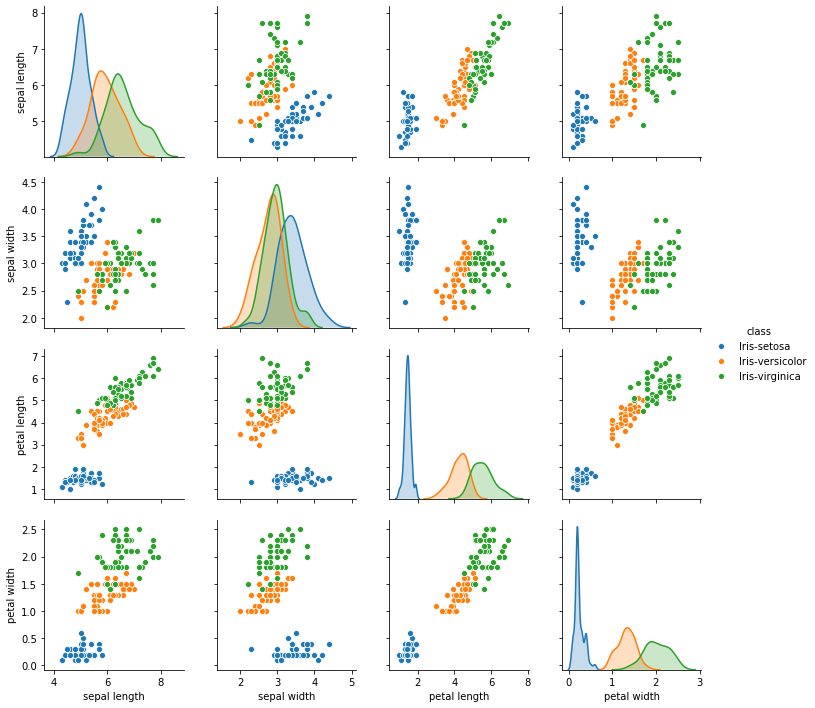

In [4]:
sns.pairplot(iris, hue = 'class')

### Lets create a “meta class” combining class 1 and class 2 (or whichever are the two most similar classes). Lets call it class 4.

In [5]:
iris['versi-virgi'] = np.where((iris['class'] == 'Iris-versicolor') | (iris['class'] == 'Iris-virginica'), 1, 0)
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class,versi-virgi
50,7.0,3.2,4.7,1.4,Iris-versicolor,1
143,6.8,3.2,5.9,2.3,Iris-virginica,1
139,6.9,3.1,5.4,2.1,Iris-virginica,1
115,6.4,3.2,5.3,2.3,Iris-virginica,1
145,6.7,3.0,5.2,2.3,Iris-virginica,1


In [6]:
train, test = train_test_split(iris, test_size=0.3)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


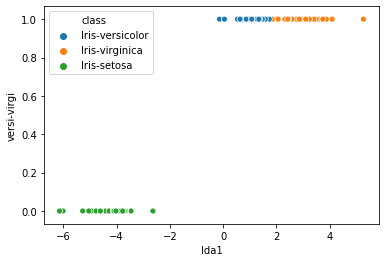

In [7]:
#Ref https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

lda = LinearDiscriminantAnalysis()
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'versi-virgi'

lda1 = lda.fit(train[features], train[target])
lda1_dis = lda1.transform(train[features])
train['lda1'] = lda1_dis

ax = sns.scatterplot(x="lda1", y="versi-virgi", hue="class", data=train)


### Create the second Fisher projection by trying to discriminate class 1 from class 2 (the original two similar classes)

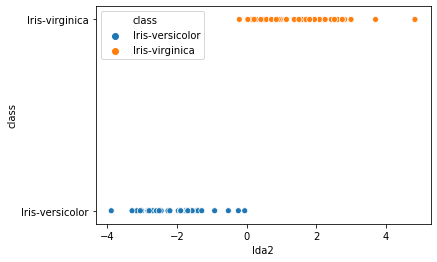

In [8]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'class'

train = train[(train['class'] == 'Iris-versicolor') | (train['class'] == 'Iris-virginica')]
lda = LinearDiscriminantAnalysis(n_components=1)
lda2 = lda.fit(train[features], train[target])
lda2_dis = lda2.transform(train[features])
train['lda2'] = lda2_dis

ax = sns.scatterplot(x="lda2", y="class", hue="class", data=train)

### Now project the entire data in these two projections and color code the class points.

In [9]:
test['lda1'] = lda1.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])
test['lda2'] = lda2.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Comment on what you observed and did.

Plot how the original four features were classifying the data

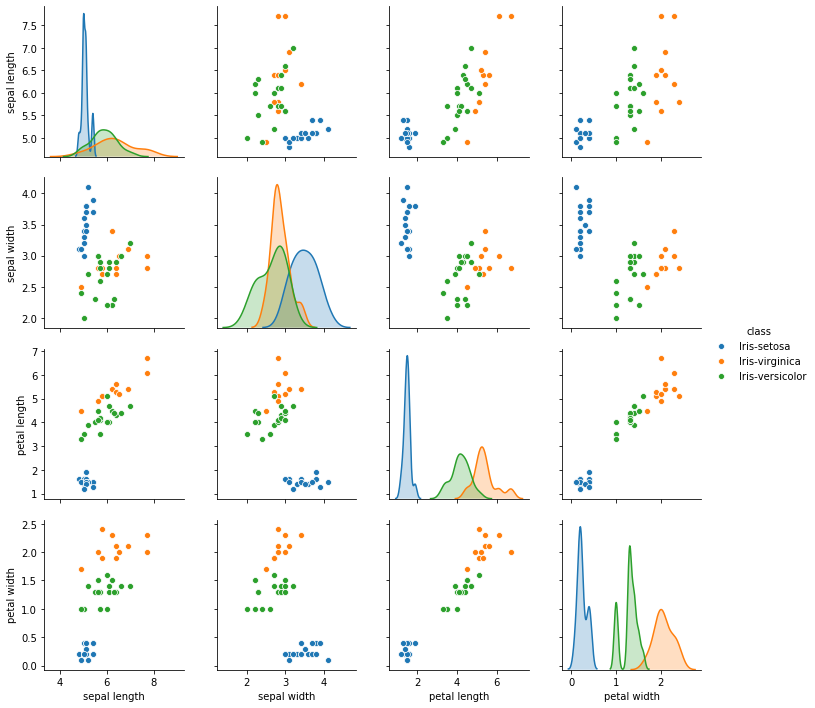

In [10]:
sns.pairplot(hue='class', data=test[['sepal length', 'sepal width', 'petal length', 'petal width', 'class']])

We can clearly see the difference between all three classes ie. setosa, versicolor and vigginica using lda projections. Which was not clear earlier using original feature. Hence it's useful projection

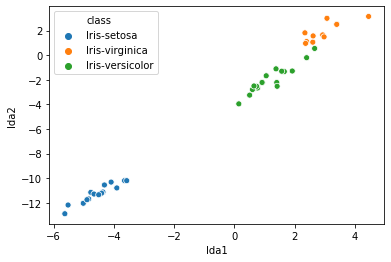

In [11]:
ax = sns.scatterplot(x="lda1", y="lda2", hue="class", data=test)

<H2> P2 : MUSHROOM information gain </H2>

### Take the MUSHROOM training data. There are 20+ features and 2 classes. We want to find the BEST feature using the three purity measures: Accuracy, Gini Index, and Entropy.

In [12]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Logic below : For each feature, partition the data into k regions where k is the number of values the feature can take.

- Take one feature at a time from dataframe
- create a subset of data with that feature and class labels
- Groupby count to partition data into K features where k is no of values feature can take

### Measure the Information gain due to each feature. Generate a table with the following columns:
- Feature_name
- Accuracy
- GINI index
- Entropy (NOTE: Use log_k for a feature with k values)

In [13]:
#define a empty dataframe for result set
result_set = pd.DataFrame(columns = ['Feature', 'Accuracy', 'Gini', '1-Entropy'])
result_set

,Feature,Accuracy,Gini,1-Entropy


In [50]:
#No. of rows
total_rows_data = mushroom.shape[0]

for column in col_names[1:] :
    df_feature_subset = mushroom[[column,'class']]
    feature_partition = df_feature_subset.groupby([column,'class']).size().unstack(fill_value=0)
    
    #Ref : https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb
    for index, row in feature_partition.iterrows():
        partition_total_sum = row['e'] + row['p']
        prob_e_class = row['e']/partition_total_sum
        prob_p_class = row['p']/partition_total_sum

        # calculate accuracy for each partition
        if(row['e'] > row['p']) :
            feature_partition.at[index,'Parition Accuracy'] = prob_e_class
        else :
            feature_partition.at[index,'Parition Accuracy'] = prob_p_class
        feature_partition.at[index,'Weighted Accuracy'] = partition_total_sum*feature_partition.loc[index,'Parition Accuracy']/total_rows_data

        #calculate gini index for each partition
        feature_partition.at[index,'Gini Index'] = prob_e_class**2 + prob_p_class**2
        feature_partition.at[index,'Weighted Gini Index'] = partition_total_sum*feature_partition.loc[index,'Gini Index']/total_rows_data

        #calculate entropy for each partition
        entropy = 0
        num_of_partitions = feature_partition.shape[0]
        if(num_of_partitions > 1) :
            #print(num_of_partitions)
            if(prob_e_class > 0) :
                entropy += prob_e_class*math.log(prob_e_class, num_of_partitions)
            if(prob_p_class > 0) :
                entropy += prob_p_class*math.log(prob_p_class, num_of_partitions)
        feature_partition.at[index,'Entropy'] = -1*entropy
        feature_partition.at[index,'Weighted Entropy'] = partition_total_sum*feature_partition.loc[index,'Entropy']/total_rows_data
    print()
    print(feature_partition)
    
    result_set = result_set.append({'Feature' : column, 
                       'Accuracy': feature_partition[['Weighted Accuracy']].sum()[0].round(4),
                       'Gini' : feature_partition[['Weighted Gini Index']].sum()[0].round(4),
                       '1-Entropy': 1-feature_partition[['Weighted Entropy']].sum()[0].round(4)}, ignore_index=True)
    
result_set.head()


class         e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
cap-shape                                                                 
b           404    48           0.893805           0.049729    0.810165   
c             0     4           1.000000           0.000492    1.000000   
f          1596  1556           0.506345           0.196455    0.500081   
k           228   600           0.724638           0.073855    0.600924   
s            32     0           1.000000           0.003939    1.000000   
x          1948  1708           0.532823           0.239783    0.502155   

class      Weighted Gini Index   Entropy  Weighted Entropy  
cap-shape                                                   
b                     0.045076  0.188912          0.010511  
c                     0.000492 -0.000000         -0.000000  
f                     0.194024  0.386808          0.150076  
k                     0.061246  0.328459          0.033477  
s                     0.003939 -


class                        e     p  Parition Accuracy  Weighted Accuracy  \
stalk-surface-above-ring                                                     
f                          408   144           0.739130           0.050222   
k                          144  2228           0.939292           0.274249   
s                         3640  1536           0.703246           0.448055   
y                           16     8           0.666667           0.001969   

class                     Gini Index  Weighted Gini Index   Entropy  \
stalk-surface-above-ring                                              
f                           0.614367             0.041744  0.414028   
k                           0.885954             0.258676  0.165125   
s                           0.582618             0.371200  0.438644   
y                           0.555556             0.001641  0.459148   

class                     Weighted Entropy  
stalk-surface-above-ring                    
f            

,Feature,Accuracy,Gini,1-Entropy
0,cap-shape,0.5643,0.5308,0.6324
1,cap-surface,0.5805,0.5200,0.5148
2,cap-color,0.5953,0.5245,0.7101
3,bruises,0.7440,0.6262,0.1933
4,odor,0.9852,0.9715,0.9707


In [15]:
result_set.tail()

,Feature,Accuracy,Gini,1-Entropy
17,ring-number,0.5382,0.5237,0.3939
18,ring-type,0.7755,0.6824,0.7067
19,spore-print-color,0.8680,0.7835,0.8365
20,population,0.7218,0.6193,0.6916
21,habitat,0.6903,0.5974,0.7000


### Plot accuracy vs. 1-Entropy scatter plot where each point is a feature.

We can see that Accuracy and '1-Entropy' are curvi linear, as Accuracy increases '1-Entropy' also increases for that feature, however there are 5 features which are outlier to this trend

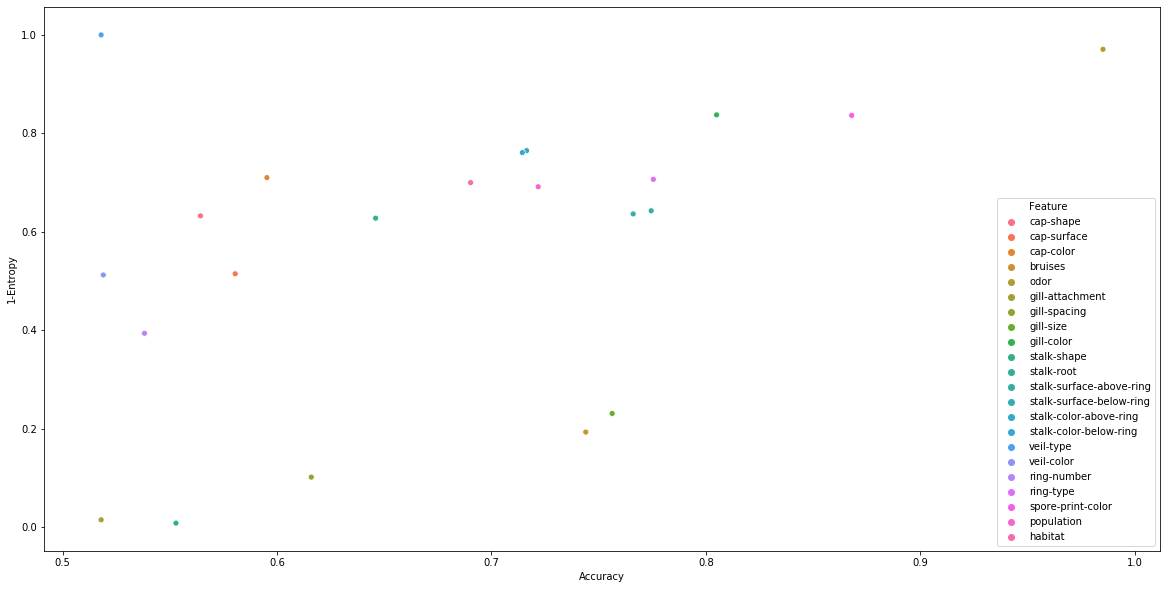

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x='Accuracy', y='1-Entropy', hue='Feature', data=result_set)

### veil-type, odor, gill-color, spore-print-color are top features which alone can define the whole data

In [17]:
result_set.sort_values(by='1-Entropy', ascending=False)

,Feature,Accuracy,Gini,1-Entropy
15,veil-type,0.5180,0.5006,1.0000
4,odor,0.9852,0.9715,0.9707
8,gill-color,0.8050,0.7321,0.8376
19,spore-print-color,0.8680,0.7835,0.8365
13,stalk-color-above-ring,0.7164,0.6382,0.7649
14,stalk-color-below-ring,0.7144,0.6329,0.7610
2,cap-color,0.5953,0.5245,0.7101
18,ring-type,0.7755,0.6824,0.7067
21,habitat,0.6903,0.5974,0.7000
20,population,0.7218,0.6193,0.6916


<h2> P3 : MUSHROOM NB/DT </h2>

In [18]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

X = mushroom.loc[:, mushroom.columns != 'class']
X = pd.get_dummies(X)
y = mushroom.loc[:, mushroom.columns == 'class']

### Build Naive Bayes and Decision Tree classifiers on the MUSHROOM training dataset.

In [19]:
#use a classic 70:30 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

df = pd.DataFrame(columns=['lambda','accuracy', 'type'])
for i in range(0,51) :
    nbc = BernoulliNB(alpha=i)
    nbc.fit(X_train, y_train.values.ravel())
    train_score = accuracy_score(y_train, nbc.predict(X_train))
    test_score = accuracy_score(y_test, nbc.predict(X_test))
    df = df.append({'lambda' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'lambda' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0 0.9945480126626802 0.9934372436423298
1 0.9386211748153359 0.9425758818703855
2 0.9322898346816743 0.9380639868744873
3 0.92842068237777 0.933552091878589
4 0.9249032711924023 0.9327317473338802
5 0.9229686950404502 0.9306808859721083
6 0.9217376011255716 0.9294503691550451
7 0.9205065072106929 0.928219852337982
8 0.9194512838550827 0.9269893355209188
9 0.9183960604994724 0.9265791632485644
10 0.9175167077031305 0.9249384741591469
11 0.9169890960253254 0.9237079573420837
12 0.9155821315511783 0.9232977850697293
13 0.9147027787548364 0.9228876127973749
14 0.9139992965177629 0.9220672682526662
15 0.9134716848399578 0.9216570959803118
16 0.9129440731621526 0.9212469237079574
17 0.9120647203658108 0.920836751435603
18 0.911712979247274 0.9200164068908941
19 0.9110094970102005 0.9196062346185397
20 0.910306014773127 0.9183757178014766
21 0.9096025325360535 0.9171452009844134
22 0.9096025325360535 0.916735028712059
23 0.9090749208582484 0.9163248564397046
24 0.9081955680619065 0.9163248564

### In Naïve Bayes classifier plot the value of lambda (x axis) for Laplacian smoothing against training and test set accuracy.

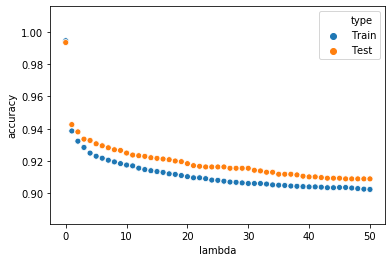

In [20]:
x = sns.scatterplot(x="lambda", y='accuracy', hue='type', data=df)

### For decision tree classifier plot the Size Threshold (x axis) against training and test set accuracy.

In [21]:
df = pd.DataFrame(columns=['size threshold','accuracy', 'type'])
for i in range(4,65,4) :
    dtc = DecisionTreeClassifier(min_samples_split=i)
    dtc.fit(X_train, y_train)
    train_score = accuracy_score(y_train, dtc.predict(X_train))
    test_score = accuracy_score(y_test, dtc.predict(X_test))
    df = df.append({'size threshold' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'size threshold' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

4 1.0 1.0
8 1.0 1.0
12 1.0 1.0
16 1.0 1.0
20 1.0 1.0
24 1.0 1.0
28 1.0 1.0
32 1.0 1.0
36 1.0 1.0
40 1.0 1.0
44 0.9982412944073162 0.9975389663658737
48 0.9982412944073162 0.9975389663658737
52 0.9982412944073162 0.9975389663658737
56 0.9982412944073162 0.9975389663658737
60 0.9982412944073162 0.9975389663658737
64 0.9982412944073162 0.9975389663658737


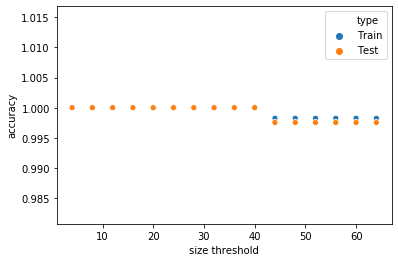

In [22]:
ax = sns.scatterplot(x="size threshold", y='accuracy', hue='type', data=df)
#ax.set_xticks(range(0,68,4))

### Find the best values of lambda and SizeThreshold where the test set accuracies starts to decrease.

In [23]:
#Get summary of best tree at threshold of 36
dtc = DecisionTreeClassifier(min_samples_split=36)
dtc.fit(X_train, y_train)
dtc.get_depth()

6

Looking at plots above, we can say -

- Naive Bayes - Even with very small lambda value for smoothening we are getting best accuracy, ie lambda- 1.0e-10, since 0 is numerically not possible. The next best is lambda = 1
- Decision Tree Classifier - Best size threshold : 36
    
Comparision -
- Naive bayes classifier are surprisingly giving better result on set set as lambda increases, compared to train set which creates doubt.
- Decision Tree Classifier are performing better than Naive Bayes with a test set accuracy of 1 at size threshold of 36, just a depth of 8.

<H2> P4 : MNIST Bayesian </H2>

### Take the MNIST dataset. Lets call it D0 dataset

In [24]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [25]:
target_names = pd.Series(mnist.label.unique()).apply(str)
print(target_names)
n_components = 9

0    1
1    0
2    4
3    7
4    3
5    5
6    8
7    9
8    2
9    6
dtype: object


### Do a 9 dimensional PCA projection . Lets call it D1 dataset

In [26]:
pca = decomposition.PCA()
pca.n_components = n_components
pca_data = pca.fit_transform(mnist_data)

### Do a 9 dimensional FISHER projection . Lets call it D2 dataset

In [27]:
model = LinearDiscriminantAnalysis(n_components=n_components)
model.fit(mnist_data, mnist_label.values.ravel())
mnist_fisher_proj_data = model.transform(mnist_data)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Build a Bayesian classifier on D1 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

Ref :
#https://stats.stackexchange.com/questions/105140/gaussian-naive-bayes-really-equivalent-to-gmm-with-diagonal-covariance-matrices
#https://scikit-learn.org/stable/modules/mixture.html#bgmm
#https://www.programcreek.com/python/example/99731/sklearn.mixture.BayesianGaussianMixture


In [28]:
def build_classifier(X_train, X_test, y_train, y_test, n_gaussians, target_names) :
    
    #Build bayesian classifier with diagnonal covariance matrix on fisher projection data
    gnb_model = GaussianNB()
    gnb_model.fit(X_train, y_train)
    y_pred = gnb_model.predict(X_test)
    nb_diag_acc = accuracy_score(y_test, y_pred)
    print("Gaussian Naive Bayes diagonal matrix : ")
    print("Train set accuracy score : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy score : ", nb_diag_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))

    #Build bayesian classifier with full covariance matrix on fisher projection data
    bgm = BayesianGaussianMixture(
                n_components = n_gaussians,
                covariance_type='full')
    bgm.fit(X_train, y_train)
    y_pred = bgm.predict(X_test)
    #print(y_pred)
    #print(y_test)
    b_full_acc = accuracy_score(y_test, y_pred)
    print("\nBayesian Gaussian mixture full covariance matrix : ")
    print("Train set accuracy : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy : ", b_full_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    #return test accuracies of both model
    return nb_diag_acc, b_full_acc

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.753452380952381
Test set accuracy score :  0.753452380952381
Classification report : 
              precision    recall  f1-score   support

           1       0.88      0.82      0.85       810
           0       0.84      0.92      0.88       951
           4       0.83      0.76      0.79       857
           7       0.70      0.68      0.69       849
           3       0.65      0.70      0.67       822
           5       0.61      0.67      0.64       779
           8       0.84      0.85      0.84       854
           9       0.87      0.83      0.85       879
           2       0.70      0.73      0.72       793
           6       0.59      0.55      0.57       806

    accuracy                           0.75      8400
   macro avg       0.75      0.75      0.75      8400
weighted avg       0.76      0.75      0.75      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.14
Test 

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


### Build a Bayesian classifier on D2 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

In [30]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.8772619047619048
Test set accuracy score :  0.8772619047619048
Classification report : 
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       825
           0       0.95      0.93      0.94       944
           4       0.86      0.84      0.85       786
           7       0.87      0.83      0.85       928
           3       0.88      0.90      0.89       760
           5       0.84      0.83      0.83       784
           8       0.91      0.91      0.91       829
           9       0.92      0.87      0.89       882
           2       0.78      0.86      0.82       837
           6       0.82      0.86      0.84       825

    accuracy                           0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.012380

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


### Compare the test accuracies of the four classifiers and comment.

diagonal covariance matrix - 
- PCA projection - test set accuracy is 0.76
- Fisher projection - test set accuracy is 0.88

If we look at classification matrix for test set, we see that on PCA data, digits 7,3,5 are performing poorly which improves with flscore of 0.83-0.9 range when doing classification modeling on fisher projection data


full covariance matrix - 
- PCA projection - test set accuracy is 0.019
- Fisher projection - test set accuracy is 0.108

## P5 : MNIST KNN / Parzen window

### Take the two datasets D1 and D2 from P4.

### Build k Nearest neighbors classifier with:
- K = 1, 3, 5, 7, 9, 11, 13, 15, 17
- Plot training and test accuracy with these values of k on x axis

In [39]:
def build_knn(X_train, X_test, y_train, y_test) :
    df = pd.DataFrame(columns=['k','accuracy', 'type'])
    for i in range(1,18,2) :
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_model.fit(X_train, y_train)
        train_score = round(accuracy_score(y_train, knn_model.predict(X_train)),4)
        test_score = round(accuracy_score(y_test, knn_model.predict(X_test)),4)
        df = df.append({'k' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
        df = df.append({'k' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
        print(i, train_score, test_score)
    return df

#### kNN on PCA data (D1)

1 1.0 0.8921
3 0.9475 0.9074
5 0.937 0.912
7 0.932 0.913
9 0.9276 0.9112
11 0.925 0.9108
13 0.9235 0.9094
15 0.9212 0.9094
17 0.9187 0.9081


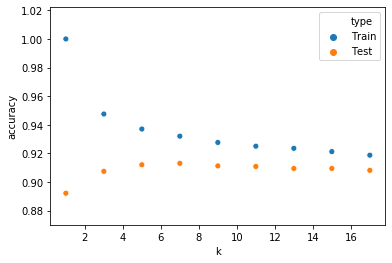

In [44]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2)
df = build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

#### kNN on fisher projection data (D2)

1 1.0 0.8977
3 0.9481 0.9096
5 0.9391 0.9133
7 0.9337 0.9151
9 0.9312 0.9156
11 0.929 0.9146
13 0.9274 0.9144
15 0.9262 0.9137
17 0.9246 0.9135


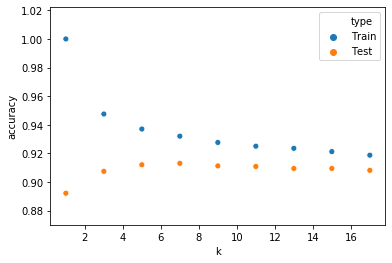

In [45]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2)
build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

### Build Parzen window classifier with:
- Sigma = 0.1, 0.2, 0.3, …, 3.0
- Plot training and test accuracies with these values of sigma.

In [ ]:
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity
df = pd.DataFrame(columns=['sigma','accuracy', 'type'])
sigma_list = []
for i in np.arange(0.1, 3.1, 0.1) :
    sigma_list.append(round(i,1))
sigma_list
for i in sigma_list :
    kde_model = KernelDensity(bandwidth=i, kernel='gaussian')
    kde_model.fit(X_train)
#     train_score = round(accuracy_score(y_train, kde_model.predict(X_train)),4)
#     test_score = round(accuracy_score(y_test, kde_model.predict(X_test)),4)
#     df = df.append({'sigma' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
#     df = df.append({'sigma' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
#     print(i, train_score, test_score)

In [ ]:
kde_model = KernelDensity(bandwidth=0.9, kernel='gaussian')
kde_model.fit(X_train)

log_prob = kde_model.score_samples(X_train)
prob_X_train = np.exp(log_prob) 
prob_X_train
#kde_model.sample(44, random_state=0)

In [ ]:
kde_model

<h2> P6 : News group Text Classifier </h2>

#### Warning : Reading multiple files may hang notebook

In [30]:
#check sample of categories and document nos.
categories = pd.read_csv("DMG-2 Assignment Data Files/Newsgroup/list.csv")
categories.sample(5)

,newsgroup,document_id
549,talk.religion.misc,84332
522,talk.religion.misc,84301
444,talk.religion.misc,84222
387,talk.religion.misc,84147
623,talk.religion.misc,84564


In [34]:
#https://stackoverflow.com/questions/35672809/how-to-read-a-list-of-txt-files-in-a-folder-in-python
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1

df = pd.DataFrame(columns=['data','document'])
text_files = glob.glob("DMG-2 Assignment Data Files/Newsgroup/*.txt")

#read all text files and create a dataframe of whole dataset
for file in text_files :
    print("Reading file .... : ", file)
    category = file[file.rfind('/')+1:-4]
    with open(file, 'r', encoding='windows-1252') as current_file :
        data = current_file.read()
        df = df.append({'data' : data,'document': category}, ignore_index=True)
        
df.sample(5)

Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/sci.crypt.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.mac.hardware.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/misc.forsale.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/soc.religion.christian.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.baseball.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.hockey.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.ibm.pc.hardware.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/talk.politics.guns.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/rec.autos.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/alt.atheism.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/comp.os.ms-windows.misc.txt
Reading file .... :  DMG-2 Assignment Data Files/Newsgroup/sci.electronics.txt
Reading file .... :  DMG-2 Assignm

,data,document
11,Newsgroup: sci.electronics\ndocument_id: 52434...,sci.electronics
16,Newsgroup: rec.motorcycles\ndocument_id: 10172...,rec.motorcycles
17,From: lipman@oasys.dt.navy.mil (Robert Lipman)...,comp.graphics
6,Newsgroup: comp.sys.ibm.pc.hardware\ndocument_...,comp.sys.ibm.pc.hardware
5,Newsgroup: rec.sport.hockey\ndocument_id: 5255...,rec.sport.hockey


In [43]:
data = df[df['document'] == 'sci.electronics'].data.values[0]

#### Build a Naïve Bayes Classifier on Newsgroup dataset

In [50]:
def clean_get_words(data) :
    # replace all non alphabetical characters with space
    data = re.sub("[^a-zA-Z]", ' ', data)
    data = data.lower()
    # make all text lowercase
    
    return data

print(clean_get_words(data))

newsgroup  sci electronics document id        from  et teal csn org  eric h  taylor  subject  re  help with tracking device  in article       fba e   ff   aesop rutgers edu  mcdonald aesop rutgers edu writes          there are a variety of water proof housings i could use but the real meat  of the problem is the electronics   hence this posting   what kind of  transmission would be reliable underwater  in murky or even night time  conditions   i m not sure if sound is feasible given the distortion under   water   obviously direction would have to be accurate but range could be  relatively short  i imagine   or    hundred yards would be more than enough     jim mcdonald  refer to patents by james harris rogers                                                                                                   he details methods of underground and underwater wireless communications  for a review  refer to  electrical experimenter   march      and june        rogers  methods were used extens

In [ ]:
news_group_dataset = re.sub("[!@#$+%*:()'-]", ' ', news_group_dataset)
news_group_dataset